In [1]:
import os
import time
import sys
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.backends import cudnn
from torch.nn import functional as F

from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

import load_so_data as so_data
import main as explor
import models
# import utils
import main

import importlib as imp
imp.reload(models)
# imp.reload(utils)
imp.reload(main)
imp.reload(so_data)
# Define data root directory

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Parameters
params = {'batch_size': 256, 'shuffle': True, 'num_workers': 6}
max_epochs = 25

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

window_len = 5*7

common_params = {
    'window_length': window_len,
    'badge_focus': 'Electorate',
    'out_dim': 'QuestionVotes',
    'data_path': '../data'
}

dset_train = so_data.StackOverflowDatasetIncCounts(dset_type='train', subsample=4000, 
                                             **common_params, self_initialise=True)
scalers = dset_train.get_scalers()
dset_test = so_data.StackOverflowDatasetIncCounts(dset_type='test', subsample=1000, 
                                             **common_params, scaler_in=scalers[0], scaler_out=scalers[1])
dset_valid = so_data.StackOverflowDatasetIncCounts(dset_type='validate', subsample=1000, centered=True,
                                             **common_params, scaler_in=scalers[0], scaler_out=scalers[1])

train_loader = DataLoader(dset_train, **params)
test_loader = DataLoader(dset_test, **params)
valid_loader = DataLoader(dset_valid, **params)

  7%|▋         | 289/4000 [00:00<00:02, 1418.90it/s]

Processing training data


100%|██████████| 4000/4000 [00:02<00:00, 1422.79it/s]


In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

dset_shape = dset_train.__getitem__(0)[0].size()
params = {
    'device': device,
    'proximity_to_badge': True
}
dset_shape

torch.Size([70, 7])

In [4]:
# model_base = models.BaselineVAECount(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
# PATH = '../models/baseline_count.pt'
# model_base.load_state_dict(torch.load(PATH, map_location=device))
# model = model_base

In [5]:
def plot_kernel(dset, model, dset_shape, device, ax=None, title="", ylim=[-20, 20]):
    
    val_in, kernel_data, val_out, val_prox, badge_date = dset.__getitem__(0)

    val_in, kernel_data, val_out, val_prox, badge_date = val_in.reshape(-1,dset_shape[0],dset_shape[1]).to(device), \
                        kernel_data.reshape(-1,window_len*2).to(device), \
                        val_out.reshape(-1,window_len*2).to(device),     \
                        val_prox.reshape(-1,dset_shape[0]).to(device),    \
                        badge_date.reshape(-1,).to(device)
    
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize=(15,5)) 
        
    recon_batch, loss_params = model(val_in, kernel_data=kernel_data, dob=badge_date, prox_to_badge=val_prox)
    mu = model.get_z(val_in, kernel_data=kernel_data, dob=badge_date, prox_to_badge=val_prox)
    
    k = model.kernel(mu, val_in, kernel_data=kernel_data)
    for k_ in k:
        ax.plot(np.arange(-5*7, 5*7), k_.detach().numpy(), alpha=1, c='blue', label='action kernel')
    
    k = model.kernel_count(mu, val_in, kernel_data=kernel_data)
    for k_ in k:
        ax.plot(np.arange(-5*7, 5*7), k_.detach().numpy(), alpha=1, c='green', label='count kernel')

    ax.axvline(x=0, lw=.5, ls='--', color='black')
    ax.axhline(y=0, lw=.5, ls='--', color='black')
    ax.set_ylim(*ylim)
    title = model.__class__ if len(title)==0 else title
    ax.set_title(title)
    
    ax.set_xlabel('Days before/after badge')
    ax.set_ylabel('Log-odds change acting probability')
    
    ax.legend(loc='best')
        
    return ax

# Plot the learnt kernels for each of the same models:

In [6]:
model_base = models.BaselineVAECount(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/baseline_count.pt'
model_base.load_state_dict(torch.load(PATH, map_location=device))
model = model_base

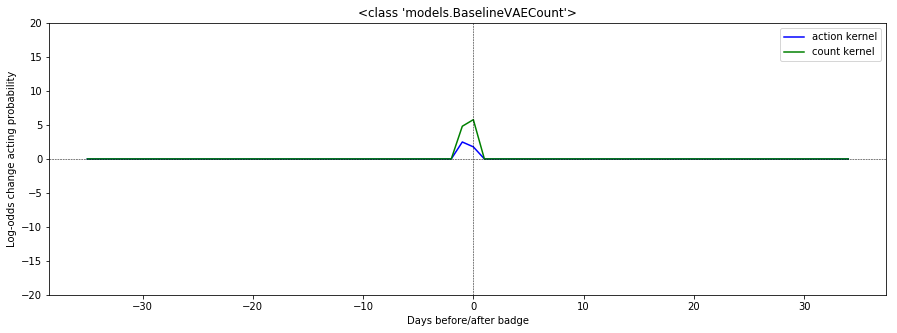

In [7]:
plot_kernel(dset_train, model, dset_shape, device)

In [8]:
model_lin = models.LinearParametricVAECount(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/linear_count.pt'
model_lin.load_state_dict(torch.load(PATH, map_location=device))
model = model_lin

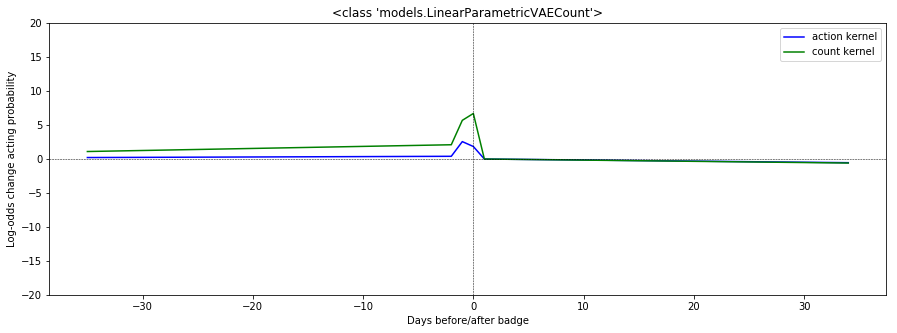

In [9]:
plot_kernel(dset_train, model, dset_shape, device)

In [10]:
model_pers_lin = models.LinearParametricPlusSteerParamVAECount(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/personalised_linear_count.pt'
model_pers_lin.load_state_dict(torch.load(PATH, map_location=device))
model = model_pers_lin

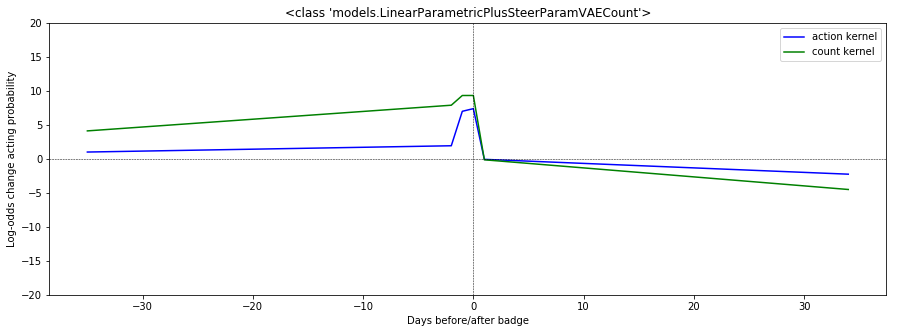

In [11]:
plot_kernel(dset_train, model, dset_shape, device)

In [12]:
model_fp = models.FullParameterisedVAECount(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/full_parameterised_count.pt'
model_fp.load_state_dict(torch.load(PATH, map_location=device))
model = model_fp

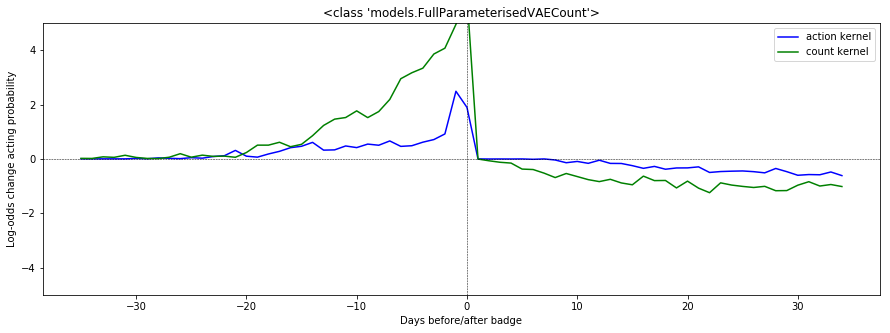

In [13]:
plot_kernel(dset_train, model, dset_shape, device, ylim=[-5,5])

In [14]:
model_pers_fp = models.FullParameterisedPlusSteerParamVAECount(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/full_personalised_parameterised_count.pt'
model_pers_fp.load_state_dict(torch.load(PATH, map_location=device))
model = model_pers_fp

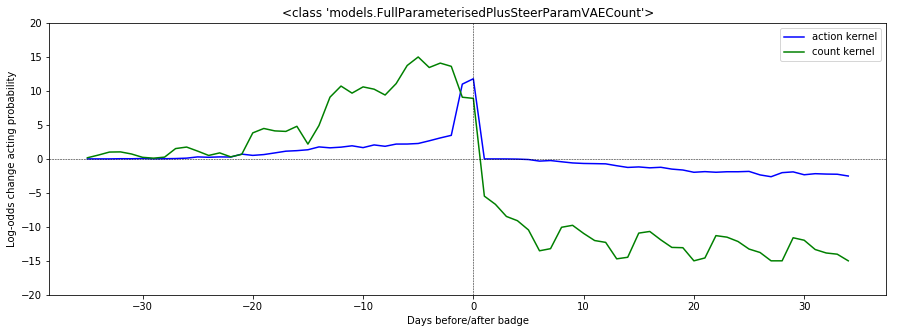

In [15]:
plot_kernel(dset_train, model, dset_shape, device, ylim=[-20,20])

In [16]:
model_pers_fp = models.NormalizingFlowFP_PlusSteer(dset_shape[0]*dset_shape[1], dset_shape[0], **params)
PATH = '../models/full_personalised_normalizing_flow.pt'
model_pers_fp.load_state_dict(torch.load(PATH, map_location=device))
model = model_pers_fp

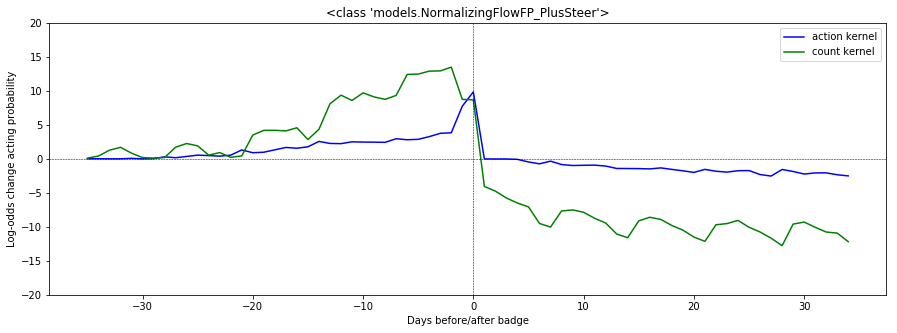

In [17]:
plot_kernel(dset_train, model, dset_shape, device, ylim=[-20,20])

In [18]:
import torch.distributions as distrib

latent_dim, latent_dim2 = [], []

p = 19

x_outs = []
recons = []
kern1 = []
kern2 = []

for loader in [train_loader, test_loader, valid_loader]:
    for x_in, kernel, x_out, prox, badge_ix in loader:
        x_in, kernel, x_out, prox, badge_ix = x_in.to(device),\
                                                kernel.to(device),\
                                                x_out.to(device),\
                                                prox.to(device),\
                                                badge_ix.to(device)

        recon_batch, loss_params = model(x_in, kernel_data=kernel, dob=badge_ix, prox_to_badge=prox)
    #     zparams = model.encode(x_in.view(-1, model.obs_dim), 
    #                                           kernel_data=kernel, 
    #                                           dob=badge_ix, 
    #                                           prox_to_badge=prox)

        cur_z = model.get_z(x_in, kernel_data=kernel, dob=badge_ix, prox_to_badge=prox)
    #     cur_z, _ = model.latent_loss(x_in.view(-1, model.obs_dim), (cur_mu,cur_sig))
    #     print(cur_mu.shape)
    #     model

    #     break
    #     cur_z, _ = model.latent_loss(x_in.view(-1, model.obs_dim), (cur_mu,cur_sig) )

        kernelz1 = model.kernel(cur_z, x_in, kernel_data=kernel)
        kernelz2 = model.kernel_count(cur_z, x_in, kernel_data=kernel)

        for i in range(len(x_out)):
            x_outs += [x_out[i].detach().numpy()]
            recons += [(recon_batch[0][i]*recon_batch[1][i]).detach().numpy()]
            kern1 += [kernelz1[i].detach().numpy()]
            kern2 += [kernelz2[i].detach().numpy()]
            latent_dim += [float(cur_z[i, -1].detach().numpy())]
            latent_dim2 += [float(cur_z[i, -2].detach().numpy())]

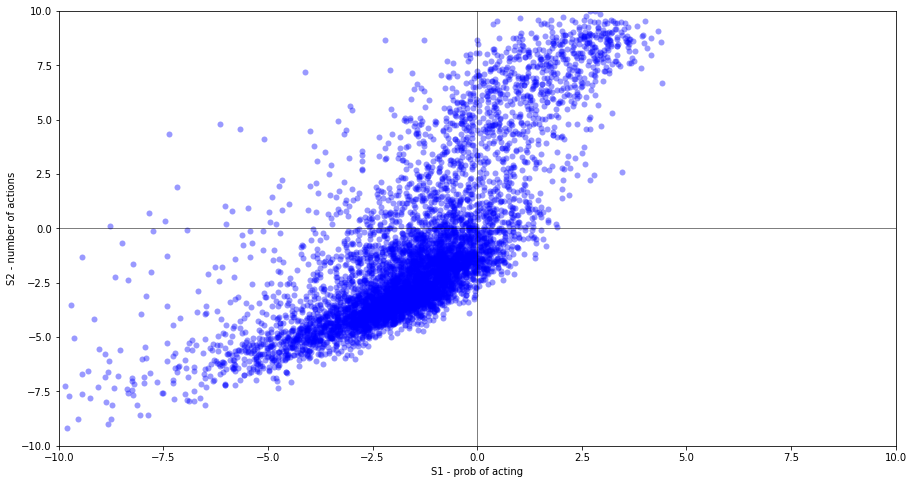

In [19]:
w1 = model.steer_weight[0].detach().numpy()
w2 = model.steer_weight[1].detach().numpy()

plt.figure(figsize=(15,8))
# plt.hexbin(w1*np.array(latent_dim), w2*np.array(latent_dim2), cmap='rainbow')
plt.scatter(w1*np.array(latent_dim), w2*np.array(latent_dim2), alpha=.4, color='blue', lw=0)

plt.xlabel('S1 - prob of acting')
plt.ylabel('S2 - number of actions')

plt.axvline(0, c='black', lw=.5)
plt.axhline(0, c='black', lw=.5)

plt.xlim([-10, 10])
plt.ylim([-10, 10])

plt.show()

In [20]:
thresh_s1 = -1
thresh_s2 = -1

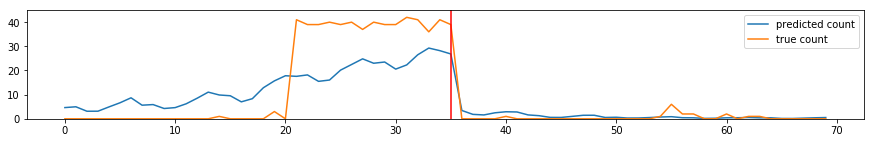

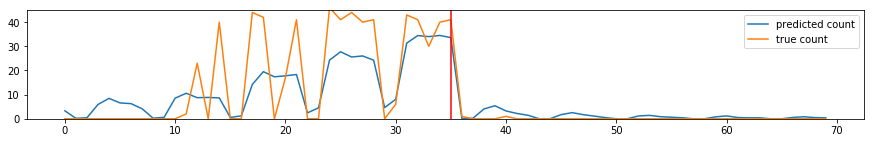

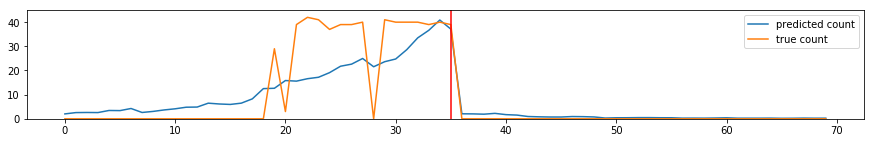

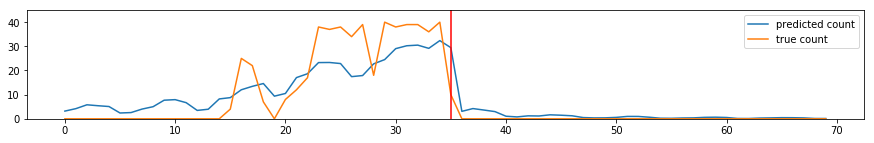

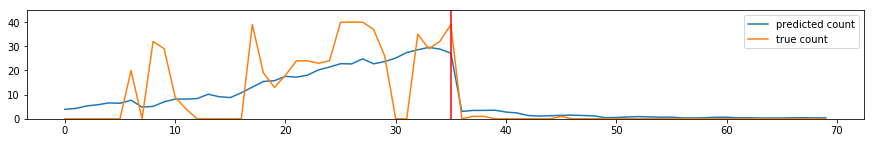

In [21]:
i = 0
top_right, top_left, bottom_right, bottom_left = [], [], [], []
top_left_s, top_right_s, bottom_right_s, bottom_left_s = [], [], [], []

for j in range(len(latent_dim)):
    if (w1*latent_dim[j] > 2 and w2*latent_dim2[j] > 2):
        
        if i > 4:
            continue
            
        top_right_s.append(1)
        top_right.append((recons[j], x_outs[j]))
        
        plt.figure(figsize=(15,2))
        plt.plot(recons[j], label='predicted count')
        
        # plt.plot(kern1[j], c='black', ls='--', alpha=.5)
        # plt.plot(kern2[j], c='green', ls='--', alpha=.5)
        plt.plot(x_outs[j], label='true count')
        plt.axvline(5*7, c='red')
        plt.ylim([0,45])
        plt.legend(loc='best')
        plt.show()
        
        i += 1
    else:
        top_right_s.append(0)

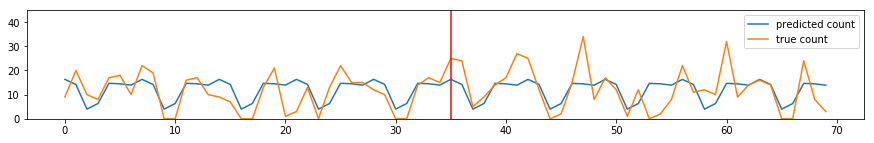

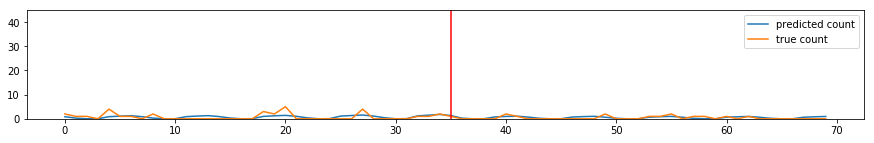

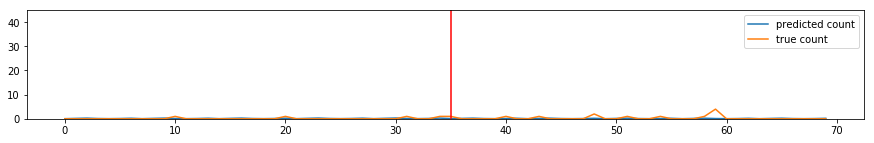

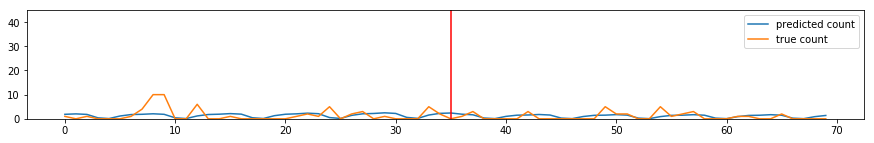

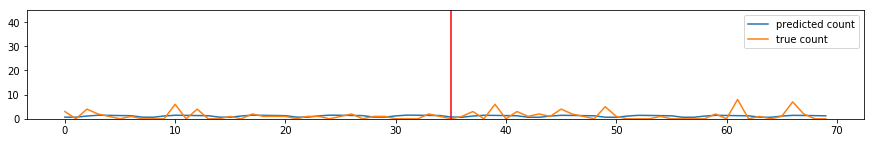

In [22]:
i = 0
for j in range(len(latent_dim)):
    if (w1*latent_dim[j] < -2 and w2*latent_dim2[j] < -2):
        
        bottom_left.append((recons[j], x_outs[j]))
        
        plt.figure(figsize=(15,2))
        plt.plot(recons[j], label='predicted count')
        # plt.plot(kern1[j], c='black', ls='--', alpha=.5)
        # plt.plot(kern2[j], c='green', ls='--', alpha=.5)
        plt.plot(x_outs[j], label='true count')
        plt.axvline(5*7, c='red')
        plt.ylim([0,45])
        plt.legend(loc='best')
        plt.show()
        
        i += 1
        
        if i > 4:
            break

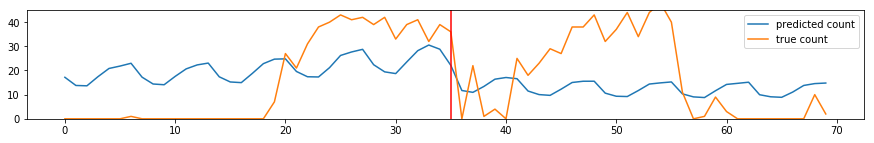

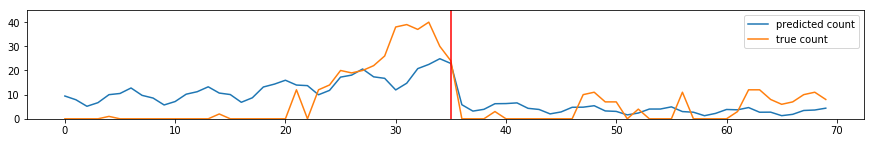

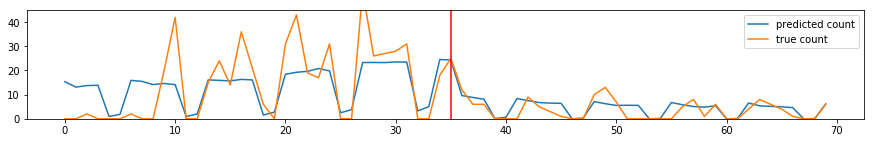

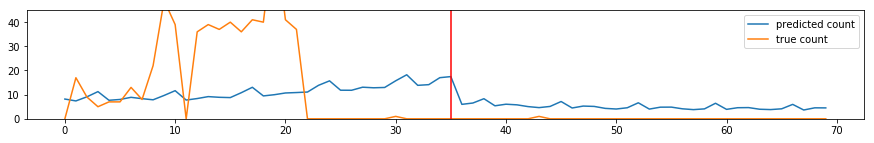

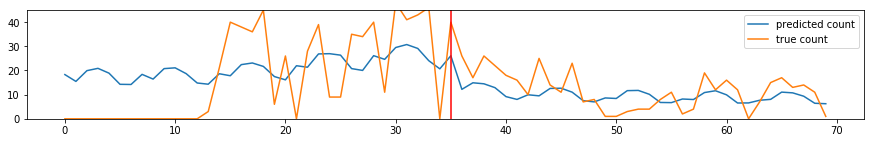

In [23]:
i = 0
for j in range(len(latent_dim)):
    if (w1*latent_dim[j] < -2 and w2*latent_dim2[j] > 2):
        
        top_left.append((recons[j], x_outs[j]))
        
        plt.figure(figsize=(15,2))
        plt.plot(recons[j], label='predicted count')
        # plt.plot(kern1[j], c='black', ls='--', alpha=.5)
        # plt.plot(kern2[j], c='green', ls='--', alpha=.5)
        plt.plot(x_outs[j], label='true count')
        plt.axvline(5*7, c='red')
        plt.ylim([0,45])
        plt.legend(loc='best')
        plt.show()
        
        i += 1
        
        if i > 4:
            break

In [24]:
i = 0
for j in range(len(latent_dim)):
    if (w1*latent_dim[j] > 2 and w2*latent_dim2[j] < -2):
        
        bottom_right.append((recons[j], x_outs[j]))
        
        plt.figure(figsize=(15,2))
        plt.plot(recons[j], label='predicted count')
        # plt.plot(kern1[j], c='black', ls='--', alpha=.5)
        # plt.plot(kern2[j], c='green', ls='--', alpha=.5)
        plt.plot(x_outs[j], label='true count')
        plt.axvline(5*7, c='red')
        plt.ylim([0,45])
        plt.legend(loc='best')
        plt.show()
        
        i += 1
        
        if i > 4:
            break

In [25]:
np.log(0.15/(1-0.15))

-1.7346010553881064

Top Right 2243 0.37383333333333335
Bottom Right 1214 0.20233333333333334
Top Left 383 0.06383333333333334
Bottom Left 2160 0.36


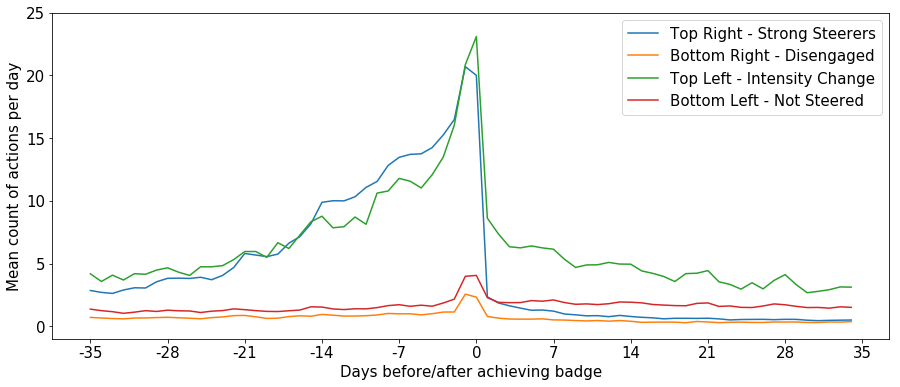

In [26]:
w1 = model.steer_weight[0].detach().numpy()
w2 = model.steer_weight[1].detach().numpy()

x_outs = np.array(x_outs)
latent_dim = np.array(latent_dim)
latent_dim2 = np.array(latent_dim2)

# plt.plot(np.mean(x_outs[(w1*latent_dim > .25) & (w2*latent_dim2 > .25)]))
w1_thresh=0
w2_thresh=0
w1_thresh_neg=-1.734
w2_thresh_neg=-1.734


center =        (w1*latent_dim > w1_thresh_neg) &\
                (w2*latent_dim2 > w2_thresh_neg)&\
                (w1*latent_dim < w1_thresh) &\
                (w2*latent_dim2 < w2_thresh)

s1_s2 =         (w1*latent_dim >= w1_thresh_neg)     & (w2*latent_dim2 >= w2_thresh_neg) | center

s1_min_s2 =     (w1*latent_dim >= w1_thresh_neg)     & (w2*latent_dim2 <= w2_thresh_neg) & ~center

min_s1_s2 =     (w1*latent_dim <= w1_thresh_neg) & (w2*latent_dim2 >= w2_thresh_neg) & ~center

min_s1_min_s2 = (w1*latent_dim <= w1_thresh_neg) & (w2*latent_dim2 <= w2_thresh_neg) & ~center

# other = 

print('Top Right', np.sum(s1_s2), np.sum(s1_s2)/len(s1_s2))
print('Bottom Right', np.sum(s1_min_s2), np.sum(s1_min_s2)/len(s1_s2))
print('Top Left', np.sum(min_s1_s2), np.sum(min_s1_s2)/len(s1_s2))
print('Bottom Left', np.sum(min_s1_min_s2), np.sum(min_s1_min_s2)/len(s1_s2))
# print('center', np.sum(center))
# print('min-S1 min-S2', np.sum(min_s1_min_s2))

plt.figure(figsize=(15,6))
plt.plot(np.mean(x_outs[s1_s2], axis=0),         label='Top Right - Strong Steerers')
plt.plot(np.mean(x_outs[s1_min_s2], axis=0),     label='Bottom Right - Disengaged')
plt.plot(np.mean(x_outs[min_s1_s2], axis=0),     label='Top Left - Intensity Change')
plt.plot(np.mean(x_outs[min_s1_min_s2], axis=0), label='Bottom Left - Not Steered')
# plt.plot(np.mean(x_outs[center], axis=0), label='Bottom Left - Not Steered')

plt.xticks(np.arange(0, 11*7, 7), np.arange(-5*7, 6*7, 7), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Days before/after achieving badge', fontsize=15)
plt.ylabel('Mean count of actions per day', fontsize=15)

plt.legend(loc='best', fontsize=15)
plt.ylim([-1,25])
# plt.plot(np.mean(x_outs[(w1*latent_dim < -.25) & (w2*latent_dim2 < -.25)], axis=0))
plt.show()

/Users/nickhoernle/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


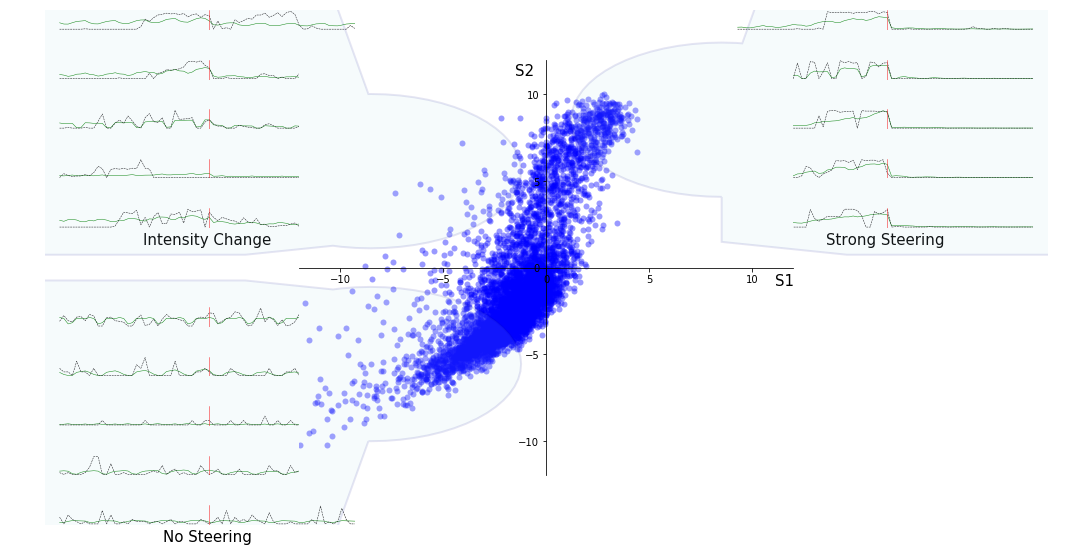

In [27]:
import matplotlib
# from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from descartes import PolygonPatch
import shapely
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.ops import cascaded_union

fig3 = plt.figure(figsize=(15,8), constrained_layout=True)

t1, t2, t3, t4, t5, t6 = .35,.1,.65,.6,.05,2


def get_polygons():
    offset = .2
    p = [
        Polygon([[ t1,  t2],[ t1,  t3],[ t4,  t6],[ t6,  t6],[ t6, t5],[ t4, t5]]),
        Polygon([[-t1, -t2],[-t1, -t3],[-t4, -t6],[-t6, -t6],[-t6,-t5],[-t4,-t5]]),
#         Polygon([[ t1, -t2],[ t1, -t3],[ t4, -t6],[ t6, -t6],[ t6,-t5],[ t4,-t5]]),
        Polygon([[-t1,  t2],[-t1,  t3],[-t4,  t6],[-t6,  t6],[-t6, t5],[-t4, t5]])
    ] + [
        Point((t1), t3-(t3-t2)/2+offset).buffer(.3),
        Point((-t1), t3-(t3-t2)/2).buffer(.3),
#         Point((t1), -(t3-(t3-t2)/2)).buffer(.3),
        Point(-(t1), -(t3-(t3-t2)/2)).buffer(.3)
    ]
    return cascaded_union(p)

def plot_line(ax, arrays):
    ax.plot(arrays[0], c='green', lw=.5)
    ax.plot(arrays[1], c='black', ls='--', lw=.5)
    ax.axvline(5*7, c='red', lw=.5)
#     ax.set_ylim([-1,40])
    return ax

gs = fig3.add_gridspec(11, 12)

top_left_axes = []
for i in range(5):
    ax = fig3.add_subplot(gs[i, :4])
    plot_line(ax, top_left[i])
    top_left_axes.append(ax)
    
bottom_left_axes = []
for i in range(5):
    ax = fig3.add_subplot(gs[6+i, :4])
    plot_line(ax, bottom_left[i])
    bottom_left_axes.append(ax)
    
top_right_axes = []
for i in range(5):
    ax = fig3.add_subplot(gs[i, -4:])
    plot_line(ax, top_right[i])
    top_right_axes.append(ax)
    
# bottom_right_axes = []
# for i in range(5):
#     ax = fig3.add_subplot(gs[6+i, -4:])
#     plot_line(ax, bottom_right[i])
#     bottom_right_axes.append(ax)
    
center_ax = fig3.add_subplot(gs[1:-1, 3:-3])
center_ax.scatter(w1*np.array(latent_dim), w2*np.array(latent_dim2), alpha=.4, color='blue', lw=0)
# center_ax.axvline(0, ymin=0.05, ymax=.95, c='black')
# center_ax.axhline(0, xmin=0.05, xmax=.95, c='black')
center_ax.set_xlim([-12,12])
center_ax.set_ylim([-12,12])

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
center_ax.spines['left'].set_position('center')
center_ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
center_ax.spines['right'].set_color('none')
center_ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
center_ax.xaxis.set_ticks_position('bottom')
center_ax.yaxis.set_ticks_position('left')

tot_ax = fig3.add_subplot(gs[:,:])
tot_ax.set_axis_off()
patch2b = PolygonPatch(get_polygons(), fc='lightblue', ec='darkblue', lw=2, alpha=.1, zorder=2)
tot_ax.add_patch(patch2b)
# tot_ax.add_patch(patch3b)
tot_ax.set_xlim([-1,1])
tot_ax.set_ylim([-1,1])

all_ax = top_left_axes + bottom_left_axes + top_right_axes
# all_ax = [center_ax]

for ax in all_ax:
#     ax.set_axis_off()
    ax.set_frame_on(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.set_xticks([])
    
    
# # left axes
# for ax in (top_left_axes + bottom_left_axes):
# #     ax.axes.get_yaxis().set_visible(False)
#     ax.axes.set_xticks([])
# #     ax.yaxis.tick_right()
#     pass 

# # right axes
# for ax in (top_right_axes + bottom_right_axes):
#     ax.axes.set_xticks([])
#     ax.yaxis.tick_right()
#     pass 

# # top axes
# for ax in (top_left_axes + top_right_axes):
#     ax.set_ylim([-1,40])
#     pass 

# # bottom axes
# for ax in (bottom_right_axes + bottom_left_axes):
#     ax.set_ylim([-1,10])
#     pass 

# add labels
top_right_axes[-1].set_xlabel('Strong Steering', fontsize=15)
# bottom_right_axes[-1].set_xlabel('Rate Change', fontsize=15)
top_left_axes[-1].set_xlabel('Intensity Change', fontsize=15)
bottom_left_axes[-1].set_xlabel('No Steering', fontsize=15)

center_ax.annotate('S2', xy=(-.1, 11.1), xytext=(-1.5, 11.1), arrowprops=None, fontsize=15)
center_ax.annotate('S1', xy=(11.1, -.1), xytext=(11.1, -1), arrowprops=None, fontsize=15)

fig3.tight_layout()
plt.show()